# Predict Future Price

---

### Import Libraries and Dependencies

In [1]:
# Initial imports
import os
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import talib

### Read CSV / API into Pandas DataFrame

In [2]:
# Loading data
# Create a list of all csv files in the data directory
data_dir = "Resources/Data/"
dir_content = os.listdir(data_dir)
data_files = [data_dir + x for x in dir_content if x.lower().endswith('.csv')]
data_files.sort()
data_files

['Resources/Data/AAPL.csv',
 'Resources/Data/AMZN.csv',
 'Resources/Data/BABA.csv',
 'Resources/Data/BTCUSD=X.csv',
 'Resources/Data/EMR.csv',
 'Resources/Data/EURUSD=X.csv',
 'Resources/Data/EXC.csv',
 'Resources/Data/F.csv',
 'Resources/Data/GBPUSD=X.csv',
 'Resources/Data/GOOG.csv',
 'Resources/Data/Gold.csv',
 'Resources/Data/HYG.csv',
 'Resources/Data/JPM.csv',
 'Resources/Data/KO.csv',
 'Resources/Data/LQD.csv',
 'Resources/Data/MMM.csv',
 'Resources/Data/MSCI Europe.csv',
 'Resources/Data/Nikkei Index.csv',
 'Resources/Data/Oil.csv',
 'Resources/Data/PFE.csv',
 'Resources/Data/Russell 2000.csv',
 'Resources/Data/SIEGY.csv',
 'Resources/Data/SPG.csv',
 'Resources/Data/SSNLF.csv',
 'Resources/Data/TSLA.csv']

### Calculate Indicators and Prepare Data

In [3]:
def add_indicators_and_signals(df):

    #df = df.drop(["Adj Close", "Ticker"], axis=1)
    
    if 'High' in df.columns:
        stock_high = df['High']
    else:
        stock_high = None
        
    if 'Low' in df.columns:
        stock_low = df['Low']
    else:
        stock_low = None
            
    if 'Open' in df.columns:
        stock_open = df['Open']
    else:
        stock_open = None
        
    if 'Volume' in df.columns:
        stock_volume = df['Volume']
    else:
        stock_volume = None
        
    if 'Adj Close' in df.columns:
        stock_close = df['Adj Close']
    else:
        stock_close = df['Close']
    
    # MACD, MACD Histogram
    df['MACD'], df['MSIG'], df['MACDH'] = talib.MACD(stock_close, fastperiod=12, slowperiod=26, signalperiod=9)

    # MACD > MSIG: Buy
    # MACD < MSIG: Sell
    df['MACD Sig'] = np.where(df['MACD'] > df['MSIG'], 1, 0) + np.where(df['MACD'] < df['MSIG'], -1, 0)

    # MACD Histogram (MACDH) 
    df['MACDH Sig'] = np.where(df['MACDH'] > 0, 1, 0) + np.where(df['MACDH'] < 0, -1, 0)
    
    # ---------------------------------------------
    
    # Compute Average Directional Index (ADX)
    if stock_low is not None and stock_high is not None:
        df['ADX'] = talib.ADX(stock_high, stock_low, stock_close, timeperiod=14)

        # ADX > 25: Strong Trend Strength 
        # ADX < 20: Weak Trend Strength
        df['ADX Sig'] = np.where(df['ADX'] > 25, 1, 0) + np.where(df['ADX'] < 20, -1, 0)
    
    # ---------------------------------------------
    
    # Compute Relatie Strength Index (RSI)
    df['RSI'] = talib.RSI(stock_close, timeperiod=14)

    # RSI < 30: Over sold -> Buy
    # RSI > 70: Over bought -> Sell
    df['RSI Sig'] = np.where(df['RSI'] < 30, 1, 0) + np.where(df['RSI'] > 70, -1, 0)
    
    # ---------------------------------------------
    
    # Compute Bollinger Bands
    df['BB Upper'], df['BB middle'], df['BB Lower'] = talib.BBANDS(stock_close, timeperiod=26)
    df['BB Sig'] = np.where(stock_close < df['BB Lower'], 1, 0) + np.where(stock_close > df['BB Upper'], -1, 0)
    
    # ---------------------------------------------
    
    # Compute Force Index
    if stock_volume is not None:
        #df['FI'] = stock_volume * (stock_close - stock_close.shift(1))
        df['FI'] = stock_volume * stock_close.diff()
        df['EFI'] = talib.EMA(df['FI'], timeperiod=13)

        # Remove Scientific Notation from columns FI and EFI
        pd.options.display.float_format = '{:.2f}'.format

        df['EFI Sig'] = np.where(df['EFI'] > 0, 1, -1)
    
    # ---------------------------------------------
    
    # Calculate 5 day simple movering average
    df['SMA 5'] = stock_close.transform(lambda x: x.rolling(window = 5).mean())

    # Calculate 15 day simple movering average
    df['SMA 15'] = stock_close.transform(lambda x: x.rolling(window = 15).mean())

    # Calculate simple moving average ratio to capture the relationship between the two moving averages
    df['SMA 15/5'] = df['SMA 15'] / df['SMA 5']

    # Calculate Signal for SMA 200/50
    df['SMA 15/5 Sig'] = np.where(df['SMA 5'] > df['SMA 15'], 1.0, 0.0) + np.where(df['SMA 5'] < df['SMA 15'], -1.0, 0.0)
    
    # --------------------------------------------
    
    # Calculate 5 day exp movering average
    df['EMA 5'] = talib.EMA(stock_close, timeperiod=5)

    # Calculate 10 day exp movering average
    df['EMA 15'] = talib.EMA(stock_close, timeperiod=15)

    # Calculate exp moving average ratio to capture the relationship between the two moving averages
    df['EMA 15/5'] = df['EMA 15'] / df['EMA 5']

    # Calculate Signal for SMA 200/50
    df['EMA 15/5 Sig'] = np.where(df['EMA 5'] > df['SMA 15'], 1.0, 0.0) + np.where(df['SMA 5'] < df['SMA 15'], -1.0, 0.0)
    
    ##############################################################
    
    # Calculate daily return
    df['Returns'] = df['Close'].pct_change()
    # Create Target column
    df['Target'] = np.where(df['Returns'] >= 0, 1.0, -1)
    
    # Shift Target column by index -1 (compare today's values with tomorrow's trend)
    df['Target'] = df['Target'].shift(-1)

    # Replacing infinite with nan 
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 

    # Dropping all the rows with nan values 
    df.dropna(inplace=True) 
    
    return df

In [4]:
def random_forest_indicators_only(df, ticker):
    # Define features set
    X = df.copy()
    
    # Drop useless columns
    signal_columns = [col for col in X.columns if col.endswith(' Sig')]
    X.drop(signal_columns, axis=1, inplace=True)
    X.drop(['Ticker', 'Returns', 'Target'], axis=1, inplace=True)

    # Some tickers do not have these indicators
    if 'ADX Sig' in X.columns:
        X.drop('ADX Sig', axis=1, inplace=True)

    if 'EFI Sig' in X.columns:
        X.drop('EFI Sig', axis=1, inplace=True)
    
    # Define target vector
    y = df["Target"].ravel()
    
    # Splitting into Train and Test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
    
    # Creating StandardScaler instance
    scaler = StandardScaler()
    
    # Fitting Standard Scaller
    X_scaler = scaler.fit(X_train)
    
    # Scaling data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create a random forest classifier
    rf_model = RandomForestClassifier(n_estimators=500, random_state=1)
    
    # Fitting the model
    rf_model = rf_model.fit(X_train_scaled, y_train)
    
    # Making predictions using the testing data
    predictions = rf_model.predict(X_test_scaled)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, predictions)
    
    # Displaying results
    print(f'\n{ticker}: Confusion Matrix (Indicators Only, No Signals)')
    display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    
    return rf_model, X.columns

In [5]:
def random_forest_signals_only(df, ticker):
    # Define features set
    X = df.copy()
    
    # Only keep signal columns
    column_to_keep = [col for col in X.columns if col.endswith(' Sig')]
    X = X[column_to_keep]
    
    # Define target vector
    y = df["Target"].ravel()
    
    # Splitting into Train and Test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
    
    # Creating StandardScaler instance
    scaler = StandardScaler()
    
    # Fitting Standard Scaller
    X_scaler = scaler.fit(X_train)
    
    # Scaling data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create a random forest classifier
    rf_model = RandomForestClassifier(n_estimators=500, random_state=1)
    
    # Fitting the model
    rf_model = rf_model.fit(X_train_scaled, y_train)
    
    # Making predictions using the testing data
    predictions = rf_model.predict(X_test_scaled)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, predictions)
    
    # Displaying results
    print(f'\n{ticker}: Confusion Matrix (Signals Only, No Indicators)')
    display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    
    return rf_model, X.columns

In [6]:
def features_importances(ticker, rf_model, X_columns):
    # Random Forests in sklearn will automatically calculate feature importance
    importances = rf_model.feature_importances_
    
    # We can sort the features by their importance
    sorted(zip(rf_model.feature_importances_, X_columns), reverse=True)
    
    # Visualize the features by importance
    importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X_columns), reverse=True))
    importances_df.set_index(importances_df[1], inplace=True)
    importances_df.drop(columns=1, inplace=True)
    importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
    importances_sorted = importances_df.sort_values(by='Feature Importances')
    
    chart = importances_sorted.plot(kind='barh', color='lightgreen', title= f'{ticker} Features Importances', legend=False) 
    plt.show()
    plt.close()
    return chart


### Run the Random Forest Model for only 1 ticker


AAPL: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,165,178
Actual 1,179,223


Accuracy Score : 0.5208053691275167
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.48      0.48       343
         1.0       0.56      0.55      0.56       402

    accuracy                           0.52       745
   macro avg       0.52      0.52      0.52       745
weighted avg       0.52      0.52      0.52       745



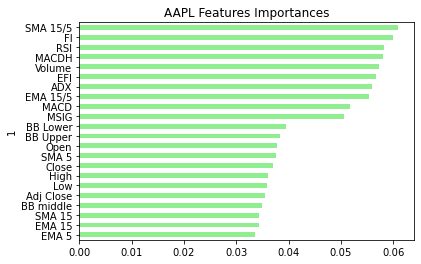


AAPL: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,149,194
Actual 1,170,232


Accuracy Score : 0.5114093959731544
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.43      0.45       343
         1.0       0.54      0.58      0.56       402

    accuracy                           0.51       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.51      0.51      0.51       745



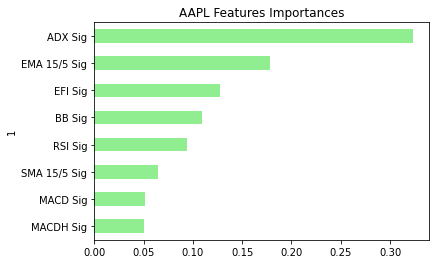

<AxesSubplot:title={'center':'AAPL Features Importances'}, ylabel='1'>

In [7]:
file_path = Path("Resources/Data/AAPL.csv")
df = pd.read_csv(file_path, index_col="Date")
ticker = df.Ticker.unique().tolist()[0]

# Calculate indicators and prepare data
df = add_indicators_and_signals(df)

# Make predictions using indicator values only and display confusion matrix
rf_model, X_columns = random_forest_indicators_only(df, ticker)

# Display importance features graph
features_importances(ticker, rf_model, X_columns)

# Make predictions using signals only and display confusion matrix
rf_model, X_columns = random_forest_signals_only(df, ticker)

# Display importance features graph
features_importances(ticker, rf_model, X_columns)

### Run the Random Forest Model for All the Data Files in the 'Resources/Data Folder'


----------------------- AAPL -----------------------


AAPL: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,165,178
Actual 1,179,223


Accuracy Score : 0.5208053691275167
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.48      0.48       343
         1.0       0.56      0.55      0.56       402

    accuracy                           0.52       745
   macro avg       0.52      0.52      0.52       745
weighted avg       0.52      0.52      0.52       745



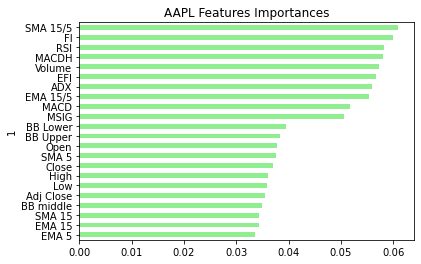

-----


AAPL: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,149,194
Actual 1,170,232


Accuracy Score : 0.5114093959731544
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.43      0.45       343
         1.0       0.54      0.58      0.56       402

    accuracy                           0.51       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.51      0.51      0.51       745



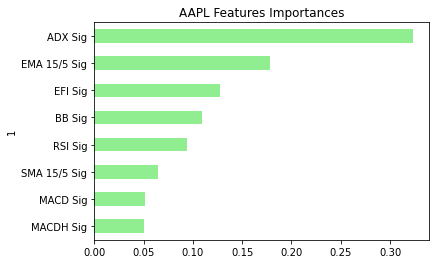


----------------------- AMZN -----------------------


AMZN: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,161,180
Actual 1,166,238


Accuracy Score : 0.5355704697986577
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.47      0.48       341
         1.0       0.57      0.59      0.58       404

    accuracy                           0.54       745
   macro avg       0.53      0.53      0.53       745
weighted avg       0.53      0.54      0.53       745



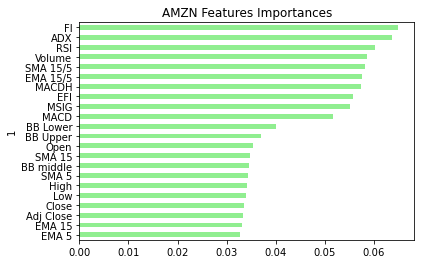

-----


AMZN: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,126,215
Actual 1,139,265


Accuracy Score : 0.5248322147651007
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.37      0.42       341
         1.0       0.55      0.66      0.60       404

    accuracy                           0.52       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.52      0.52      0.52       745



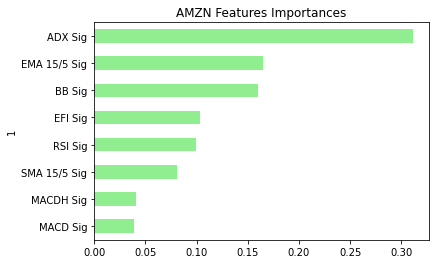


----------------------- BABA -----------------------


BABA: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,89,97
Actual 1,76,127


Accuracy Score : 0.5552699228791774
Classification Report
              precision    recall  f1-score   support

        -1.0       0.54      0.48      0.51       186
         1.0       0.57      0.63      0.59       203

    accuracy                           0.56       389
   macro avg       0.55      0.55      0.55       389
weighted avg       0.55      0.56      0.55       389



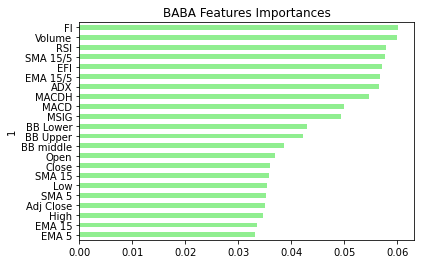

-----


BABA: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,83,103
Actual 1,98,105


Accuracy Score : 0.4832904884318766
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.45      0.45       186
         1.0       0.50      0.52      0.51       203

    accuracy                           0.48       389
   macro avg       0.48      0.48      0.48       389
weighted avg       0.48      0.48      0.48       389



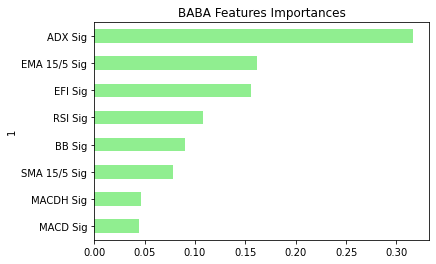


----------------------- BTCUSD=X -----------------------


BTCUSD=X: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,151,178
Actual 1,158,243


Accuracy Score : 0.5397260273972603
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.46      0.47       329
         1.0       0.58      0.61      0.59       401

    accuracy                           0.54       730
   macro avg       0.53      0.53      0.53       730
weighted avg       0.54      0.54      0.54       730



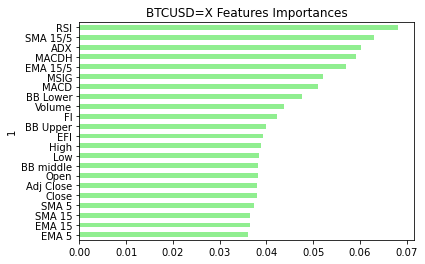

-----


BTCUSD=X: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,98,231
Actual 1,113,288


Accuracy Score : 0.5287671232876713
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.30      0.36       329
         1.0       0.55      0.72      0.63       401

    accuracy                           0.53       730
   macro avg       0.51      0.51      0.49       730
weighted avg       0.51      0.53      0.51       730



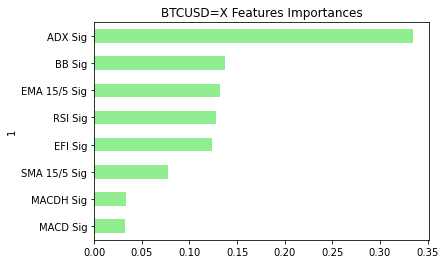


----------------------- EMR -----------------------


EMR: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,155,198
Actual 1,157,235


Accuracy Score : 0.5234899328859061
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.44      0.47       353
         1.0       0.54      0.60      0.57       392

    accuracy                           0.52       745
   macro avg       0.52      0.52      0.52       745
weighted avg       0.52      0.52      0.52       745



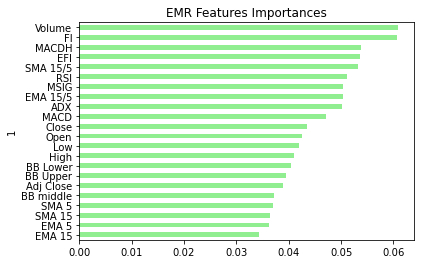

-----


EMR: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,61,292
Actual 1,67,325


Accuracy Score : 0.5181208053691275
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.17      0.25       353
         1.0       0.53      0.83      0.64       392

    accuracy                           0.52       745
   macro avg       0.50      0.50      0.45       745
weighted avg       0.50      0.52      0.46       745



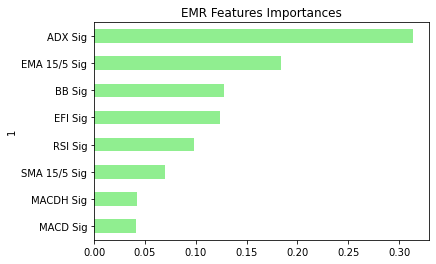


----------------------- EURUSD=X -----------------------


EURUSD=X: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,220,169
Actual 1,168,208


Accuracy Score : 0.5594771241830065
Classification Report
              precision    recall  f1-score   support

        -1.0       0.57      0.57      0.57       389
         1.0       0.55      0.55      0.55       376

    accuracy                           0.56       765
   macro avg       0.56      0.56      0.56       765
weighted avg       0.56      0.56      0.56       765



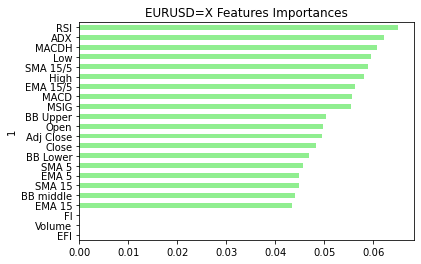

-----


EURUSD=X: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,150,239
Actual 1,157,219


Accuracy Score : 0.4823529411764706
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.39      0.43       389
         1.0       0.48      0.58      0.53       376

    accuracy                           0.48       765
   macro avg       0.48      0.48      0.48       765
weighted avg       0.48      0.48      0.48       765



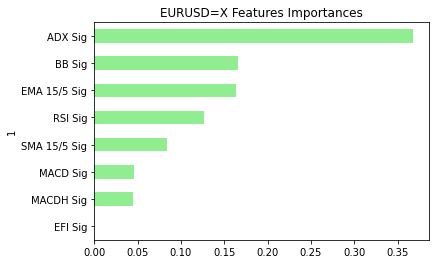


----------------------- EXC -----------------------


EXC: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,182,170
Actual 1,163,230


Accuracy Score : 0.553020134228188
Classification Report
              precision    recall  f1-score   support

        -1.0       0.53      0.52      0.52       352
         1.0       0.57      0.59      0.58       393

    accuracy                           0.55       745
   macro avg       0.55      0.55      0.55       745
weighted avg       0.55      0.55      0.55       745



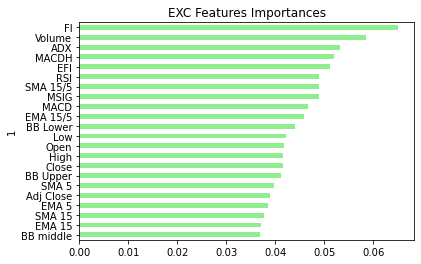

-----


EXC: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,120,232
Actual 1,143,250


Accuracy Score : 0.4966442953020134
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.34      0.39       352
         1.0       0.52      0.64      0.57       393

    accuracy                           0.50       745
   macro avg       0.49      0.49      0.48       745
weighted avg       0.49      0.50      0.49       745



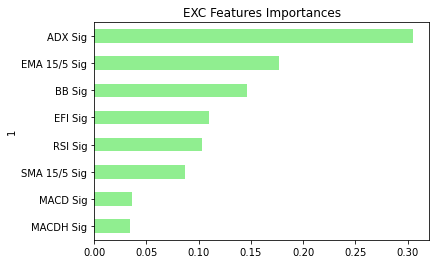


----------------------- F -----------------------


F: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,176,160
Actual 1,206,203


Accuracy Score : 0.508724832214765
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.52      0.49       336
         1.0       0.56      0.50      0.53       409

    accuracy                           0.51       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.51      0.51      0.51       745



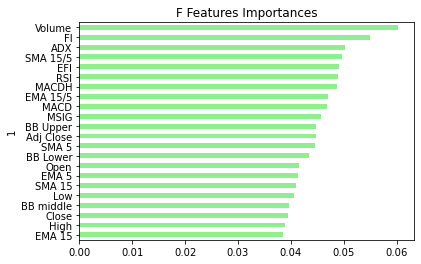

-----


F: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,112,224
Actual 1,126,283


Accuracy Score : 0.5302013422818792
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.33      0.39       336
         1.0       0.56      0.69      0.62       409

    accuracy                           0.53       745
   macro avg       0.51      0.51      0.50       745
weighted avg       0.52      0.53      0.52       745



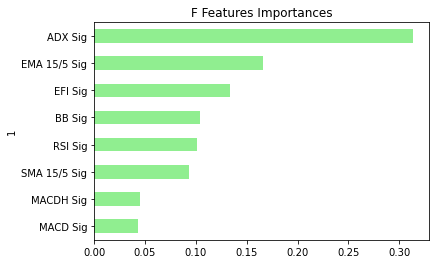


----------------------- GBPUSD=X -----------------------


GBPUSD=X: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,223,159
Actual 1,178,205


Accuracy Score : 0.5594771241830065
Classification Report
              precision    recall  f1-score   support

        -1.0       0.56      0.58      0.57       382
         1.0       0.56      0.54      0.55       383

    accuracy                           0.56       765
   macro avg       0.56      0.56      0.56       765
weighted avg       0.56      0.56      0.56       765



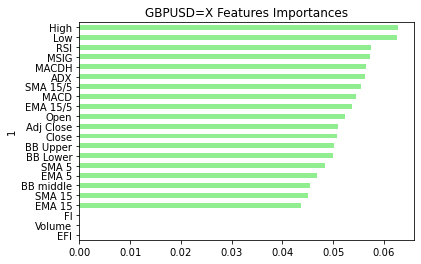

-----


GBPUSD=X: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,197,185
Actual 1,188,195


Accuracy Score : 0.5124183006535947
Classification Report
              precision    recall  f1-score   support

        -1.0       0.51      0.52      0.51       382
         1.0       0.51      0.51      0.51       383

    accuracy                           0.51       765
   macro avg       0.51      0.51      0.51       765
weighted avg       0.51      0.51      0.51       765



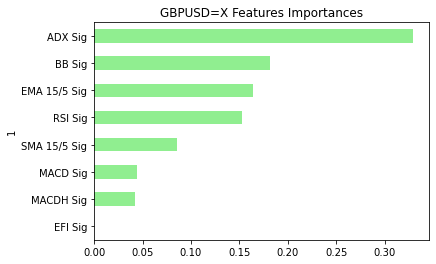


----------------------- GOOG -----------------------


GOOG: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,182,157
Actual 1,195,211


Accuracy Score : 0.5275167785234899
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.54      0.51       339
         1.0       0.57      0.52      0.55       406

    accuracy                           0.53       745
   macro avg       0.53      0.53      0.53       745
weighted avg       0.53      0.53      0.53       745



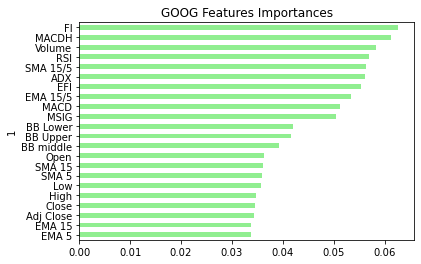

-----


GOOG: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,177,162
Actual 1,214,192


Accuracy Score : 0.49530201342281877
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.52      0.48       339
         1.0       0.54      0.47      0.51       406

    accuracy                           0.50       745
   macro avg       0.50      0.50      0.50       745
weighted avg       0.50      0.50      0.50       745



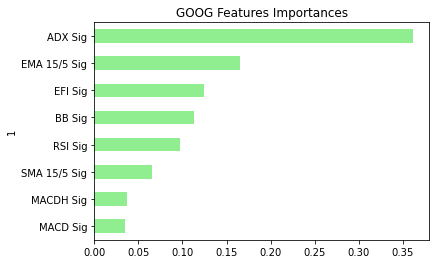


----------------------- Gold -----------------------


Gold: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,177,205
Actual 1,161,202


Accuracy Score : 0.508724832214765
Classification Report
              precision    recall  f1-score   support

        -1.0       0.52      0.46      0.49       382
         1.0       0.50      0.56      0.52       363

    accuracy                           0.51       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.51      0.51      0.51       745



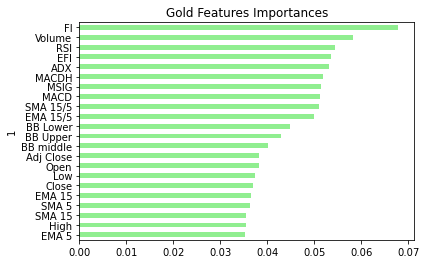

-----


Gold: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,119,263
Actual 1,99,264


Accuracy Score : 0.5140939597315436
Classification Report
              precision    recall  f1-score   support

        -1.0       0.55      0.31      0.40       382
         1.0       0.50      0.73      0.59       363

    accuracy                           0.51       745
   macro avg       0.52      0.52      0.49       745
weighted avg       0.52      0.51      0.49       745



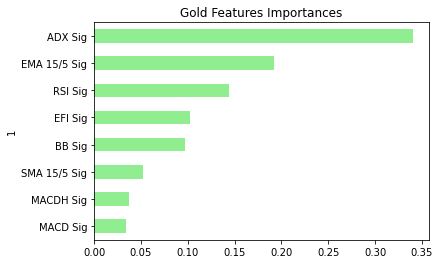


----------------------- HYG -----------------------


HYG: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,166,183
Actual 1,159,237


Accuracy Score : 0.5409395973154363
Classification Report
              precision    recall  f1-score   support

        -1.0       0.51      0.48      0.49       349
         1.0       0.56      0.60      0.58       396

    accuracy                           0.54       745
   macro avg       0.54      0.54      0.54       745
weighted avg       0.54      0.54      0.54       745



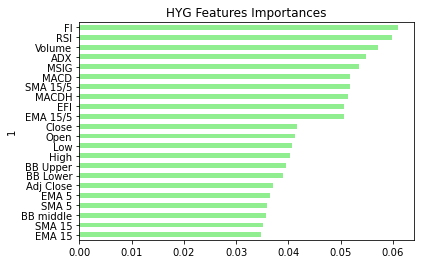

-----


HYG: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,93,256
Actual 1,100,296


Accuracy Score : 0.5221476510067115
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.27      0.34       349
         1.0       0.54      0.75      0.62       396

    accuracy                           0.52       745
   macro avg       0.51      0.51      0.48       745
weighted avg       0.51      0.52      0.49       745



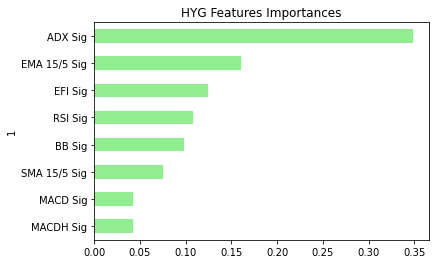


----------------------- JPM -----------------------


JPM: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,161,181
Actual 1,198,205


Accuracy Score : 0.4912751677852349
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.47      0.46       342
         1.0       0.53      0.51      0.52       403

    accuracy                           0.49       745
   macro avg       0.49      0.49      0.49       745
weighted avg       0.49      0.49      0.49       745



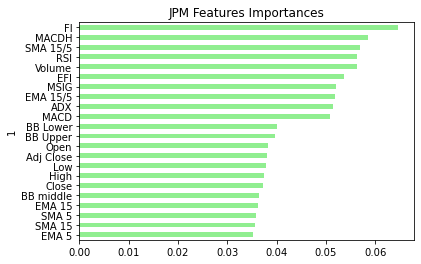

-----


JPM: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,125,217
Actual 1,171,232


Accuracy Score : 0.4791946308724832
Classification Report
              precision    recall  f1-score   support

        -1.0       0.42      0.37      0.39       342
         1.0       0.52      0.58      0.54       403

    accuracy                           0.48       745
   macro avg       0.47      0.47      0.47       745
weighted avg       0.47      0.48      0.47       745



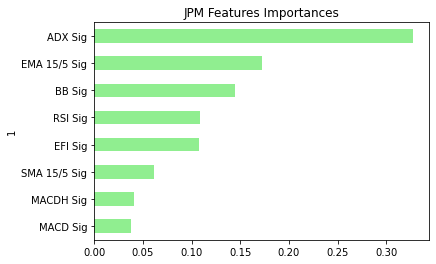


----------------------- KO -----------------------


KO: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,145,203
Actual 1,152,245


Accuracy Score : 0.5234899328859061
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.42      0.45       348
         1.0       0.55      0.62      0.58       397

    accuracy                           0.52       745
   macro avg       0.52      0.52      0.51       745
weighted avg       0.52      0.52      0.52       745



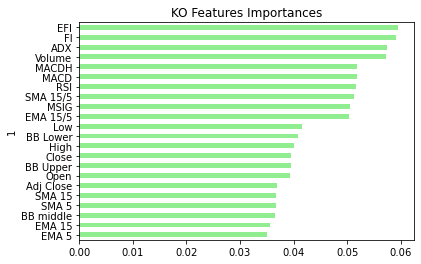

-----


KO: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,125,223
Actual 1,130,267


Accuracy Score : 0.5261744966442953
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.36      0.41       348
         1.0       0.54      0.67      0.60       397

    accuracy                           0.53       745
   macro avg       0.52      0.52      0.51       745
weighted avg       0.52      0.53      0.51       745



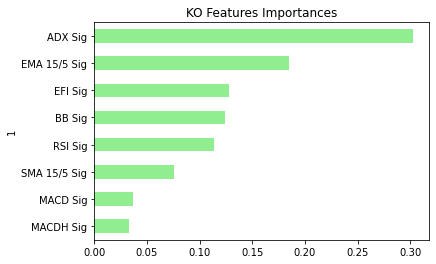


----------------------- LQD -----------------------


LQD: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,132,198
Actual 1,134,281


Accuracy Score : 0.5543624161073826
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.40      0.44       330
         1.0       0.59      0.68      0.63       415

    accuracy                           0.55       745
   macro avg       0.54      0.54      0.54       745
weighted avg       0.55      0.55      0.55       745



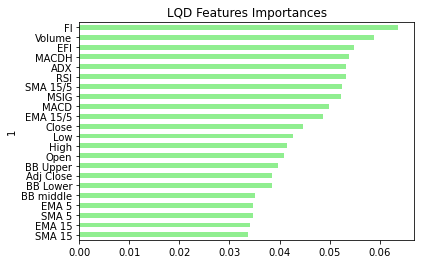

-----


LQD: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,90,240
Actual 1,134,281


Accuracy Score : 0.49798657718120803
Classification Report
              precision    recall  f1-score   support

        -1.0       0.40      0.27      0.32       330
         1.0       0.54      0.68      0.60       415

    accuracy                           0.50       745
   macro avg       0.47      0.47      0.46       745
weighted avg       0.48      0.50      0.48       745



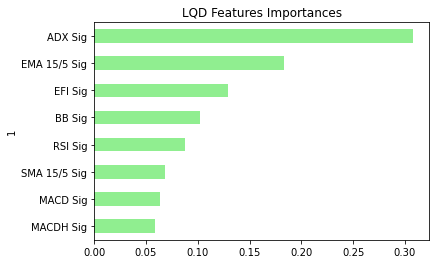


----------------------- MMM -----------------------


MMM: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,149,201
Actual 1,145,250


Accuracy Score : 0.5355704697986577
Classification Report
              precision    recall  f1-score   support

        -1.0       0.51      0.43      0.46       350
         1.0       0.55      0.63      0.59       395

    accuracy                           0.54       745
   macro avg       0.53      0.53      0.53       745
weighted avg       0.53      0.54      0.53       745



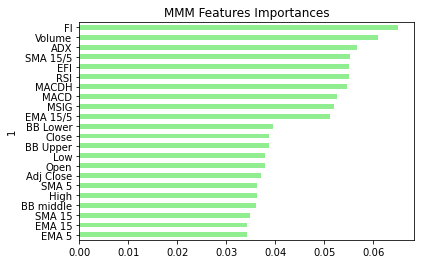

-----


MMM: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,99,251
Actual 1,112,283


Accuracy Score : 0.512751677852349
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.28      0.35       350
         1.0       0.53      0.72      0.61       395

    accuracy                           0.51       745
   macro avg       0.50      0.50      0.48       745
weighted avg       0.50      0.51      0.49       745



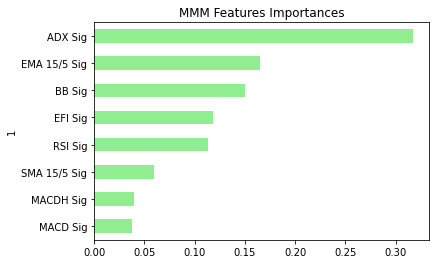


----------------------- MSCI Europe -----------------------


MSCI Europe: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,829,986
Actual 1,788,1263


Accuracy Score : 0.5411277806518365
Classification Report
              precision    recall  f1-score   support

        -1.0       0.51      0.46      0.48      1815
         1.0       0.56      0.62      0.59      2051

    accuracy                           0.54      3866
   macro avg       0.54      0.54      0.54      3866
weighted avg       0.54      0.54      0.54      3866



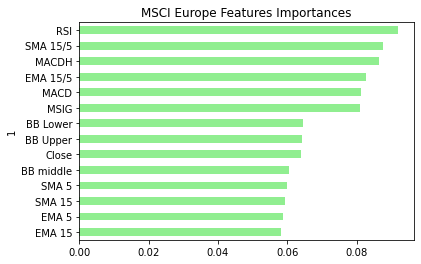

-----


MSCI Europe: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,108,1707
Actual 1,123,1928


Accuracy Score : 0.5266425245732023
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.06      0.11      1815
         1.0       0.53      0.94      0.68      2051

    accuracy                           0.53      3866
   macro avg       0.50      0.50      0.39      3866
weighted avg       0.50      0.53      0.41      3866



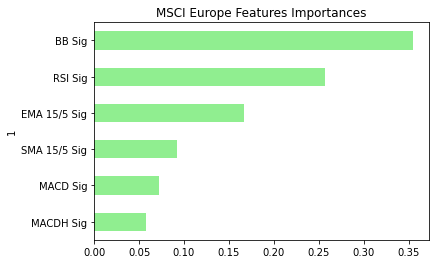


----------------------- Nikkei Index -----------------------


Nikkei Index: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,150,185
Actual 1,187,203


Accuracy Score : 0.4868965517241379
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.45      0.45       335
         1.0       0.52      0.52      0.52       390

    accuracy                           0.49       725
   macro avg       0.48      0.48      0.48       725
weighted avg       0.49      0.49      0.49       725



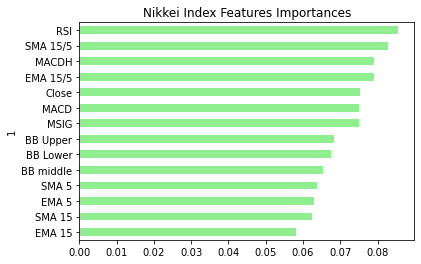

-----


Nikkei Index: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,35,300
Actual 1,48,342


Accuracy Score : 0.52
Classification Report
              precision    recall  f1-score   support

        -1.0       0.42      0.10      0.17       335
         1.0       0.53      0.88      0.66       390

    accuracy                           0.52       725
   macro avg       0.48      0.49      0.42       725
weighted avg       0.48      0.52      0.43       725



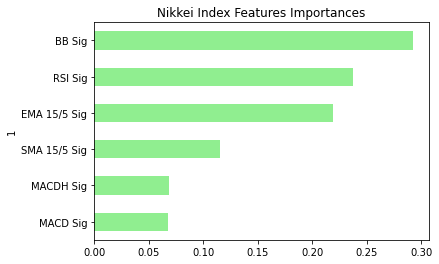


----------------------- Oil -----------------------


Oil: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,42,163
Actual 1,62,380


Accuracy Score : 0.652241112828439
Classification Report
              precision    recall  f1-score   support

        -1.0       0.40      0.20      0.27       205
         1.0       0.70      0.86      0.77       442

    accuracy                           0.65       647
   macro avg       0.55      0.53      0.52       647
weighted avg       0.61      0.65      0.61       647



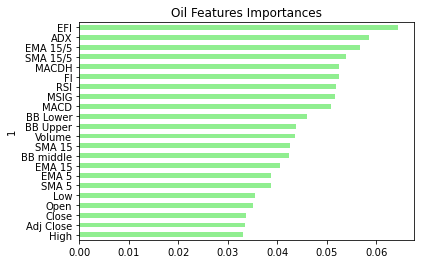

-----


Oil: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,8,197
Actual 1,14,428


Accuracy Score : 0.6738794435857806
Classification Report
              precision    recall  f1-score   support

        -1.0       0.36      0.04      0.07       205
         1.0       0.68      0.97      0.80       442

    accuracy                           0.67       647
   macro avg       0.52      0.50      0.44       647
weighted avg       0.58      0.67      0.57       647



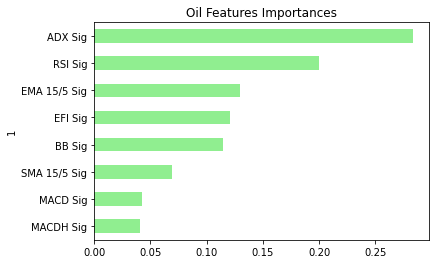


----------------------- PFE -----------------------


PFE: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,160,175
Actual 1,186,224


Accuracy Score : 0.5154362416107383
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.48      0.47       335
         1.0       0.56      0.55      0.55       410

    accuracy                           0.52       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.52      0.52      0.52       745



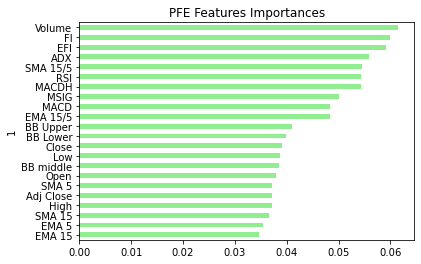

-----


PFE: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,210,125
Actual 1,251,159


Accuracy Score : 0.49530201342281877
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.63      0.53       335
         1.0       0.56      0.39      0.46       410

    accuracy                           0.50       745
   macro avg       0.51      0.51      0.49       745
weighted avg       0.51      0.50      0.49       745



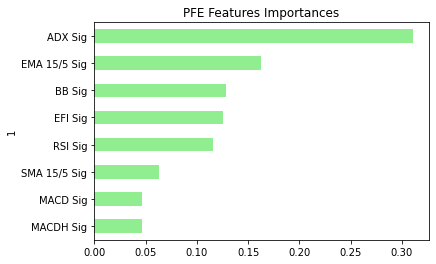


----------------------- Russell 2000 -----------------------


Russell 2000: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,151,168
Actual 1,186,240


Accuracy Score : 0.5248322147651007
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.47      0.46       319
         1.0       0.59      0.56      0.58       426

    accuracy                           0.52       745
   macro avg       0.52      0.52      0.52       745
weighted avg       0.53      0.52      0.53       745



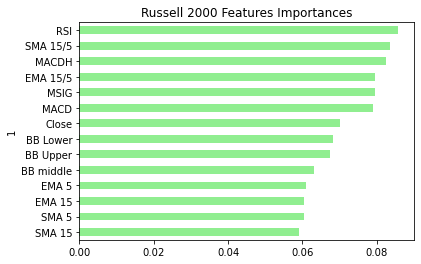

-----


Russell 2000: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,25,294
Actual 1,34,392


Accuracy Score : 0.5597315436241611
Classification Report
              precision    recall  f1-score   support

        -1.0       0.42      0.08      0.13       319
         1.0       0.57      0.92      0.71       426

    accuracy                           0.56       745
   macro avg       0.50      0.50      0.42       745
weighted avg       0.51      0.56      0.46       745



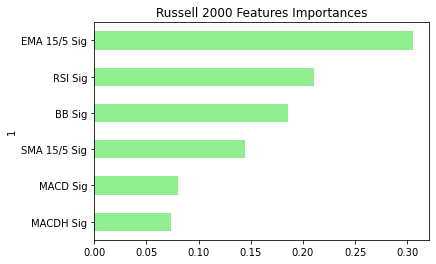


----------------------- SIEGY -----------------------


SIEGY: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,177,181
Actual 1,180,207


Accuracy Score : 0.5154362416107383
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.49      0.50       358
         1.0       0.53      0.53      0.53       387

    accuracy                           0.52       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.52      0.52      0.52       745



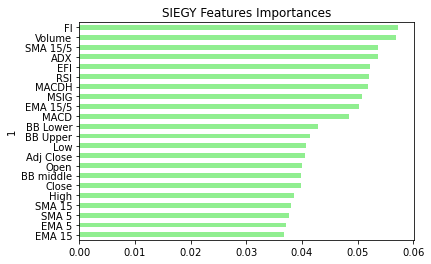

-----


SIEGY: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,181,177
Actual 1,192,195


Accuracy Score : 0.5046979865771812
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.51      0.50       358
         1.0       0.52      0.50      0.51       387

    accuracy                           0.50       745
   macro avg       0.50      0.50      0.50       745
weighted avg       0.51      0.50      0.50       745



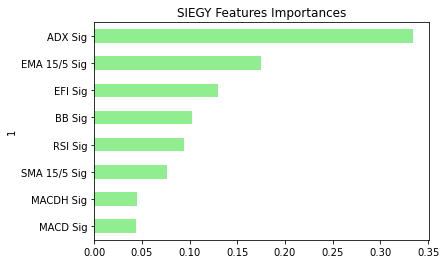


----------------------- SPG -----------------------


SPG: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,154,170
Actual 1,205,216


Accuracy Score : 0.4966442953020134
Classification Report
              precision    recall  f1-score   support

        -1.0       0.43      0.48      0.45       324
         1.0       0.56      0.51      0.54       421

    accuracy                           0.50       745
   macro avg       0.49      0.49      0.49       745
weighted avg       0.50      0.50      0.50       745



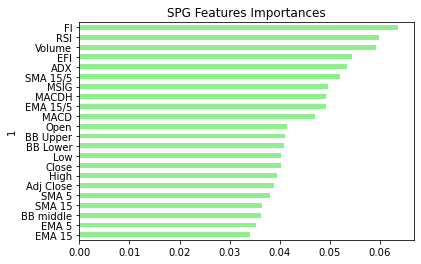

-----


SPG: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,108,216
Actual 1,138,283


Accuracy Score : 0.5248322147651007
Classification Report
              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.38       324
         1.0       0.57      0.67      0.62       421

    accuracy                           0.52       745
   macro avg       0.50      0.50      0.50       745
weighted avg       0.51      0.52      0.51       745



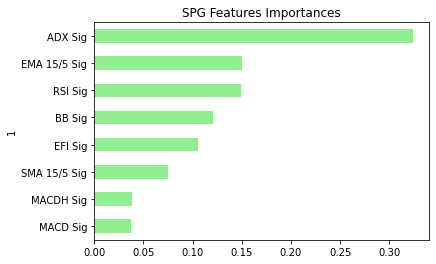


----------------------- SSNLF -----------------------


SSNLF: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,0,7
Actual 1,1,264


Accuracy Score : 0.9705882352941176
Classification Report
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         7
         1.0       0.97      1.00      0.99       265

    accuracy                           0.97       272
   macro avg       0.49      0.50      0.49       272
weighted avg       0.95      0.97      0.96       272



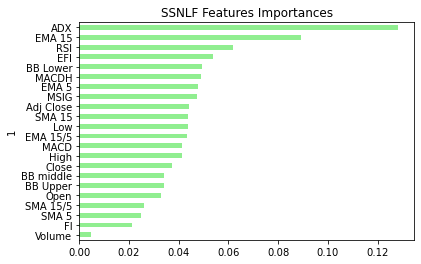

-----


SSNLF: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,0,7
Actual 1,0,265


Accuracy Score : 0.9742647058823529
Classification Report
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         7
         1.0       0.97      1.00      0.99       265

    accuracy                           0.97       272
   macro avg       0.49      0.50      0.49       272
weighted avg       0.95      0.97      0.96       272



C:\Users\wazar\anaconda3\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


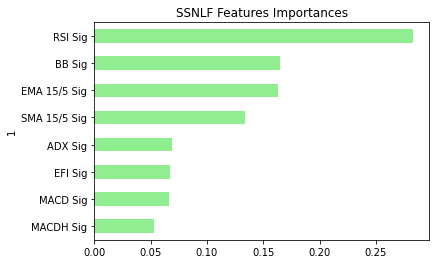


----------------------- TSLA -----------------------


TSLA: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,172,185
Actual 1,159,192


Accuracy Score : 0.5141242937853108
Classification Report
              precision    recall  f1-score   support

        -1.0       0.52      0.48      0.50       357
         1.0       0.51      0.55      0.53       351

    accuracy                           0.51       708
   macro avg       0.51      0.51      0.51       708
weighted avg       0.51      0.51      0.51       708



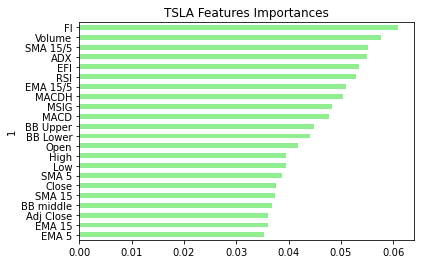

-----


TSLA: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,114,243
Actual 1,87,264


Accuracy Score : 0.5338983050847458
Classification Report
              precision    recall  f1-score   support

        -1.0       0.57      0.32      0.41       357
         1.0       0.52      0.75      0.62       351

    accuracy                           0.53       708
   macro avg       0.54      0.54      0.51       708
weighted avg       0.54      0.53      0.51       708



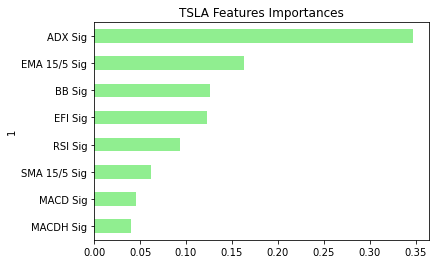

In [8]:
for file in data_files:
    tmp_df = pd.read_csv(Path(file), index_col="Date")
    ticker = tmp_df.Ticker.unique().tolist()[0]
    print(f'\n----------------------- {ticker} -----------------------\n')
    
    # Calculate indicators and prepare data
    tmp_df = add_indicators_and_signals(tmp_df)

    # Use only the indicator values, no signals
    # Make predictions and display confusion matrix
    rf_model, X_columns = random_forest_indicators_only(tmp_df, ticker)

    # Display importance features graph
    features_importances(ticker, rf_model, X_columns)
    
    print("-----\n")
    
    # Use only the signal values no indicator values
    # Make predictions and display confusion matrix
    rf_model, X_columns = random_forest_signals_only(tmp_df, ticker)
    
    # Display importance features graph
    features_importances(ticker, rf_model, X_columns)
    